In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm

from ISLP import load_data
# Formatting
from ISLP.models import (ModelSpec as MS, summarize)

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 4.1 Stock market data

### Data overview
- Time series data with qualitative varaible "Direction"

In [7]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


### Correlation matrix computation

In [12]:
# corr() for column-wise corr
Smarket.iloc[:, 1:6].corr()

,Lag1,Lag2,Lag3,Lag4,Lag5
Lag1,1.000000,-0.026294,-0.010803,-0.002986,-0.005675
Lag2,-0.026294,1.000000,-0.025897,-0.010854,-0.003558
Lag3,-0.010803,-0.025897,1.000000,-0.024051,-0.018808
Lag4,-0.002986,-0.010854,-0.024051,1.000000,-0.027084
Lag5,-0.005675,-0.003558,-0.018808,-0.027084,1.000000


<Axes: >

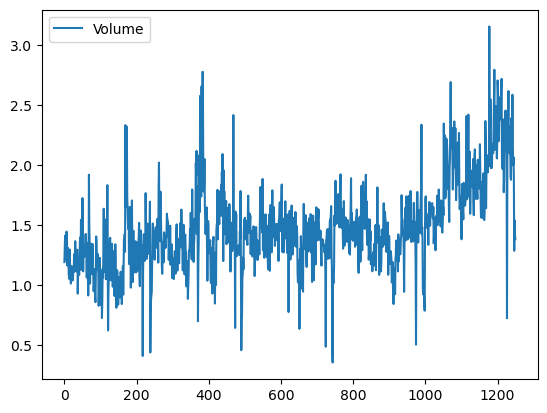

In [13]:
Smarket.plot(y='Volume')

# 4.2 Logistic Regression

## 4.2.1 Using Lag1-Lag5 and Volume
- Use `sm.GLM()` to fit generalized linear models
    - Parameter `family=sm.families.Binomial()` -> Logistic regression
    
- Or use `sm.Logit()` to fit a logistic regression

In [14]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
# add const term
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
# Using sm methods
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


### Attributtes and Methods of `GLMResult`
- params
- pvalues
- predict()

In [15]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [17]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [21]:
probs =results.predict()
print('prediction length: ', len(probs))
print(probs[:10])

prediction length:  1250
[0.50708413 0.48146788 0.48113883 0.51522236 0.51078116 0.50695646
 0.49265087 0.50922916 0.51761353 0.48883778]


In [24]:
labels = np.array(['Up' if p > 0.5 else 'Down' for p in probs])
labels

array(['Up', 'Down', 'Down', ..., 'Up', 'Up', 'Up'], dtype='<U4')

### `ISLP.confusion_table()`: calculate correct/incorrectly classified
- diagonal entries: correct entries
- off diagonal entriies: incorrect

In [26]:
ct = confusion_table(labels, Smarket.Direction)
ct

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [27]:
type(ct)

pandas.core.frame.DataFrame

In [32]:
# hit ratio
np.mean(labels == Smarket.Direction)

0.5216

### Testing set
- Use `predict(exog=X_test)` to predict out of sample points

In [34]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [36]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, famility=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

/Users/sun/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['famility']
  warnings.warn(msg, ValueWarning)


In [37]:
len(probs)

252

In [41]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]
labels = ['Up' if p > 0.5 else 'Down' for p in probs]

In [43]:
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [45]:
"test accuracy = {ta:.4f}, test error rate = {er:.4f}".format(ta=np.mean(labels==L_test),er=np.mean(labels!=L_test), )

'test accuracy = 0.4802, test error rate = 0.5198'

## 4.2.2 Using only Lag1 and Lag2

- The data has no date label, hence it is hard to use acf and pacf to determine lag terms. I will just follow the book's instruction

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [59]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X

,intercept,Lag1,Lag2
0,1.0,0.381,-0.192
1,1.0,0.959,0.381
2,1.0,1.032,0.959
3,1.0,-0.623,1.032
4,1.0,0.614,-0.623
...,...,...,...
1245,1.0,0.422,0.252
1246,1.0,0.043,0.422
1247,1.0,-0.955,0.043
1248,1.0,0.130,-0.955


In [63]:
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = ['Up' if p > 0.5 else 'Down' for p in probs]
ct = confusion_table(labels, L_test)
ct

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


141

### Extra: grid search best subset

In [91]:
def subset_result(subset: list):
    if not subset:
        return 0
    train = (Smarket.Year < 2005)
    model = MS(subset).fit(Smarket)
    X = model.transform(Smarket)
    X_train, X_test = X.loc[train], X.loc[~train]
    glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
    results = glm_train.fit()
    probs = results.predict(exog=X_test)
    labels = ['Up' if p > 0.5 else 'Down' for p in probs]
    ct = confusion_table(labels, L_test)
    correct = 0
    for i in range(len(ct)):
        correct += ct.iloc[i, i]
    total = ct.sum().sum()
    return correct / total

In [73]:
possible_subsets = list(Smarket.columns[1:6])
possible_subsets

['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']

In [78]:
def generate_subsets(lst):
    if not lst:
        return [[]]  # Return an empty list as the base case

    subsets_without_first = generate_subsets(lst[1:])
    subsets_with_first = [[lst[0]] + subset for subset in subsets_without_first]

    return subsets_without_first + subsets_with_first

all_subsets = generate_subsets(possible_subsets)
all_subsets

[[],
 ['Lag5'],
 ['Lag4'],
 ['Lag4', 'Lag5'],
 ['Lag3'],
 ['Lag3', 'Lag5'],
 ['Lag3', 'Lag4'],
 ['Lag3', 'Lag4', 'Lag5'],
 ['Lag2'],
 ['Lag2', 'Lag5'],
 ['Lag2', 'Lag4'],
 ['Lag2', 'Lag4', 'Lag5'],
 ['Lag2', 'Lag3'],
 ['Lag2', 'Lag3', 'Lag5'],
 ['Lag2', 'Lag3', 'Lag4'],
 ['Lag2', 'Lag3', 'Lag4', 'Lag5'],
 ['Lag1'],
 ['Lag1', 'Lag5'],
 ['Lag1', 'Lag4'],
 ['Lag1', 'Lag4', 'Lag5'],
 ['Lag1', 'Lag3'],
 ['Lag1', 'Lag3', 'Lag5'],
 ['Lag1', 'Lag3', 'Lag4'],
 ['Lag1', 'Lag3', 'Lag4', 'Lag5'],
 ['Lag1', 'Lag2'],
 ['Lag1', 'Lag2', 'Lag5'],
 ['Lag1', 'Lag2', 'Lag4'],
 ['Lag1', 'Lag2', 'Lag4', 'Lag5'],
 ['Lag1', 'Lag2', 'Lag3'],
 ['Lag1', 'Lag2', 'Lag3', 'Lag5'],
 ['Lag1', 'Lag2', 'Lag3', 'Lag4'],
 ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]

In [92]:
result = []
for s in all_subsets:
    result.append([s, subset_result(s)])
result.sort(key=lambda x:x[1], reverse=True)

In [93]:
result

[[['Lag2', 'Lag5'], 0.5952380952380952],
 [['Lag2', 'Lag3', 'Lag4'], 0.5952380952380952],
 [['Lag2'], 0.5912698412698413],
 [['Lag2', 'Lag4', 'Lag5'], 0.5912698412698413],
 [['Lag2', 'Lag3'], 0.5912698412698413],
 [['Lag2', 'Lag3', 'Lag4', 'Lag5'], 0.5912698412698413],
 [['Lag1', 'Lag2', 'Lag3'], 0.5912698412698413],
 [['Lag1', 'Lag2', 'Lag3', 'Lag5'], 0.5912698412698413],
 [['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5'], 0.5873015873015873],
 [['Lag2', 'Lag3', 'Lag5'], 0.5833333333333334],
 [['Lag2', 'Lag4'], 0.5793650793650794],
 [['Lag1', 'Lag2', 'Lag3', 'Lag4'], 0.5793650793650794],
 [['Lag1', 'Lag2', 'Lag4'], 0.5753968253968254],
 [['Lag1', 'Lag2', 'Lag4', 'Lag5'], 0.5714285714285714],
 [['Lag1', 'Lag2', 'Lag5'], 0.5674603174603174],
 [['Lag5'], 0.5595238095238095],
 [['Lag4'], 0.5595238095238095],
 [['Lag4', 'Lag5'], 0.5595238095238095],
 [['Lag3'], 0.5595238095238095],
 [['Lag3', 'Lag5'], 0.5595238095238095],
 [['Lag3', 'Lag4'], 0.5595238095238095],
 [['Lag3', 'Lag4', 'Lag5'], 0.55952

### Predict new data point

In [96]:
newdata = pd.DataFrame({'Lag1': [1.2, 1.5],
                        'Lag2': [1.1, -0.8]})

newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

# 4.3 Linear Discrinimant Analysis
### LDA fit

In [97]:
lda = LDA(store_covariance=True)

In [99]:
# LDA will add an intercept automatically. Need to remove it manually.
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]


In [102]:
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

### lda attributes

In [103]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [104]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [105]:
lda.priors_

array([0.49198397, 0.50801603])

In [116]:
# scalings_ are the betas of Y = beta.T* X
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

### Testing Set Accuracy

In [117]:
lda_pred = lda.predict(X_test)
confusion_table(lda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [130]:
# comma for specific columns or rows
lda_prob = lda.predict_proba(X_test)
# print(lda_prob)
print(lda_prob.shape, "converted to", lda_prob[:,1].shape)

(252, 2) converted to (252,)


In [134]:
np.all(np.where(lda_prob[:,1]>=0.5, 'Up', 'Down') == lda_pred)

True

In [151]:
# Taking lda_prob[:,1] is because lda.classes_[1] = 'Up'
# Alternative
np.all(np.where(lda_prob[:,1]>=0.5, lda.classes_[1], lda.classes_[0]) == lda_pred)

True

In [135]:
np.all(np.where(lda_prob[:,1]>=0.6, 'Up', 'Down') == lda_pred)

False

In [140]:
# For more than 2 classes
np.all([lda.classes_[i] for i in np.argmax(lda_prob , 1)] == lda_pred)

True

# 4.4 Quadratic Discriminant Analysis

### Fitting process

In [141]:
qda = QDA(store_covariance=True)
qda.fit(X_train , L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

### Attributes

In [142]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [144]:
qda.priors_

array([0.49198397, 0.50801603])

### Predict

In [145]:
qda_pred = qda.predict(X_test)

In [177]:
ct = confusion_table(qda_pred , L_test)
ct 

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [178]:
qda_accurate = 0
for i in range(len(ct)):
    qda_accurate += ct.iloc[i, i]
"QDA accuray = {ac:.2f}%".format(ac=qda_accurate*100/ct.sum().sum())

'QDA accuray = 59.92%'

In [147]:
qda_pred

array(['Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Up',
       'Down', 'Down', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Down', 'Up',
       'Up', 'Up', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down',
       'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Down', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Down', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Down', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down',
       'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down', 'Down', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 

In [152]:
# We can also get a posterior
qda_prob = qda.predict_proba(X_test)
qda_prob

array([[0.48732434, 0.51267566],
       [0.47590106, 0.52409894],
       [0.46369106, 0.53630894],
       [0.4739253 , 0.5260747 ],
       [0.49034262, 0.50965738],
       [0.49135613, 0.50864387],
       [0.49229512, 0.50770488],
       [0.48474475, 0.51525525],
       [0.48895945, 0.51104055],
       [0.48189708, 0.51810292],
       [0.49006837, 0.50993163],
       [0.50880851, 0.49119149],
       [0.48948096, 0.51051904],
       [0.46882683, 0.53117317],
       [0.47227939, 0.52772061],
       [0.47778697, 0.52221303],
       [0.49110913, 0.50889087],
       [0.50027167, 0.49972833],
       [0.49558246, 0.50441754],
       [0.48576016, 0.51423984],
       [0.49783819, 0.50216181],
       [0.50882262, 0.49117738],
       [0.50199361, 0.49800639],
       [0.48908979, 0.51091021],
       [0.50115524, 0.49884476],
       [0.5029427 , 0.4970573 ],
       [0.48859351, 0.51140649],
       [0.47736702, 0.52263298],
       [0.48754913, 0.51245087],
       [0.50318414, 0.49681586],
       [0.

# 4.5 Naive Bayes

### Fitting 

In [153]:
NB = GaussianNB()
NB.fit(X_train , L_train)

GaussianNB()

### Attributes

In [154]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [155]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [156]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [158]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

The number of rows is equal to the number of classes,  while the number of columns is equal to the number of features.

Verify:
- mean: 
    - X_train[class=class_1].mean() = [feature1class1_mean, feature2class1_mean]
    - X_train[class=class_2].mean() = [feature1class2_mean, feature2class2_mean]
    - NB.theta_ = [X_train[class=class_1].mean(), X_train[class=class_2].mean()]
- variance:
    - X_train[class=class_1].var(ddof=0) = [feature1class1_var, feature2class1_var]
    - X_train[class=class_2].var(ddof=0) = [feature1class2_var, feature2class2_var]
    - NB.var_ = [X_train[class=class_1].var(ddof=0), X_train[class=class_2].var(ddof=0)]
    - The GaussianNB() function calculates variances using the 1/n formula(ddof=0)

In [159]:
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [160]:
X_train[L_train == 'Up'].mean()

Lag1   -0.039546
Lag2   -0.031325
dtype: float64

In [162]:
X_train[L_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

### Predict and test

In [167]:
nb_labels = NB.predict(X_test)
ct = confusion_table(nb_labels , L_test)
ct

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [164]:
NB.predict_proba(X_test)

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413],
       [0.49121017, 0.50878983],
       [0.4921853 , 0.5078147 ],
       [0.48452749, 0.51547251],
       [0.48875624, 0.51124376],
       [0.48157179, 0.51842821],
       [0.48958781, 0.51041219],
       [0.50910287, 0.49089713],
       [0.48836745, 0.51163255],
       [0.47013577, 0.52986423],
       [0.47322167, 0.52677833],
       [0.47830144, 0.52169856],
       [0.49094329, 0.50905671],
       [0.50026186, 0.49973814],
       [0.49544145, 0.50455855],
       [0.48577498, 0.51422502],
       [0.49745783, 0.50254217],
       [0.50911006, 0.49088994],
       [0.50197202, 0.49802798],
       [0.48893946, 0.51106054],
       [0.50064207, 0.49935793],
       [0.5025187 , 0.4974813 ],
       [0.48858671, 0.51141329],
       [0.47748726, 0.52251274],
       [0.48728425, 0.51271575],
       [0.50324168, 0.49675832],
       [0.

In [176]:
nb_accurate = 0
for i in range(len(ct)):
    nb_accurate += ct.iloc[i, i]
"Naive Bayes accuray = {ac:.2f}%".format(ac=nb_accurate*100/ct.sum().sum())

'Naive Bayes accuray = 59.52%'

# 4.6 K-Neareast Neighbor

### fit and predict

In [180]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train , L_train)
knn1_pred = knn1.predict(X_test)
tc = confusion_table(knn1_pred , L_test)
tc

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [181]:
accuracy = sum([tc.iloc[i, i] for i in range(len(tc))])/tc.sum().sum()
accuracy

0.5

In [184]:
accuracy_alternative = np.mean(knn1_pred == L_test)
accuracy_alternative

0.5

In [194]:
knn_df = pd.DataFrame(columns=['K', 'Accuracy'])
for K in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train , L_train)
    knn_pred = knn.predict(X_test)
    accuracy = np.mean(knn_pred == L_test)
    knn_df.loc[K] = [K, accuracy]

<Axes: >

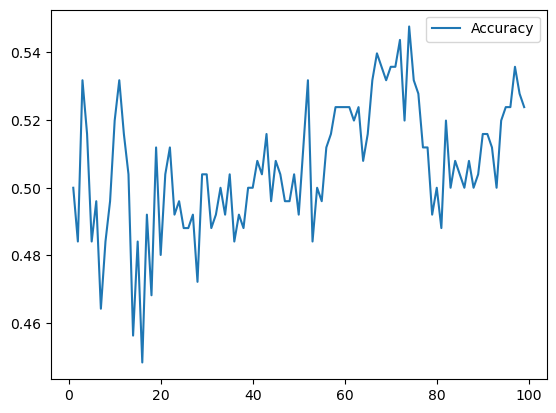

In [195]:
knn_df.plot(y='Accuracy')

### Conclusion
KNN does not perform well on the Smarket data, but it often does provide impressive results. 

## Using `Caravan` data


### Data overview

In [3]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [4]:
Caravan

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,No
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,Yes
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,No


### Preproecess
- Since there are large scale features. We need `sklearn.preprocessing.StandardScaler` to scale

In [10]:
feature_df = Caravan.drop(columns=['Purchase'])
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)

In [11]:
scaler.fit(feature_df)
scaler

StandardScaler()

In [13]:
X_std = scaler.transform(feature_df)
feature_std = pd.DataFrame(
    X_std ,
    columns=feature_df.columns)

feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [14]:
X_std.shape

(5822, 85)

### Training

In [15]:
(X_train ,X_test, y_train , y_test) = train_test_split(feature_std,
                                                       Purchase ,
                                                       test_size=1000,
                                                       random_state=0)

In [24]:
y_train

621      No
3352     No
1520     No
977      No
2234     No
       ... 
4931     No
3264     No
1653     No
2607    Yes
2732     No
Name: Purchase, Length: 4822, dtype: object

In [16]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_result = knn1.fit(X_train , y_train)

In [17]:
knn1_result

KNeighborsClassifier(n_neighbors=1)

In [31]:
X_test

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
840,0.213820,-0.27258,-2.125697,2.466192,0.079251,-0.694311,0.217444,-1.051594,0.464159,-1.667319,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
3338,0.525211,-0.27258,1.672893,-1.216964,0.429328,-0.694311,2.548861,-1.051594,-2.039739,-0.619824,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
2976,-1.187437,-0.27258,0.406697,-1.216964,-0.970980,-0.694311,-0.365410,0.914172,0.464159,0.951417,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
5114,-1.187437,-0.27258,0.406697,-1.216964,-0.970980,0.302552,-0.365410,0.914172,-0.161816,-0.096077,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
527,0.525211,-0.27258,-0.859500,0.010755,0.429328,2.296276,0.217444,-1.051594,-0.787790,1.475164,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,-1.810219,-0.27258,-0.859500,1.238473,-1.671134,-0.694311,0.217444,0.914172,-0.787790,1.475164,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
582,-1.732371,-0.27258,0.406697,0.010755,-1.671134,0.302552,0.800298,-0.068711,-0.787790,-0.096077,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,4.589446,-0.087348,-0.118816
873,0.603059,-0.27258,-0.859500,1.238473,0.429328,1.299414,0.800298,-1.051594,-1.413765,-0.096077,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
480,0.603059,-0.27258,-0.859500,0.010755,0.429328,-0.694311,0.217444,-0.068711,-0.161816,-0.096077,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816


- Tip: sklearn has bugs with 1.3.0 here: we should use `X_test.values`
- In 1.2.2, we use `X_test`

In [18]:
knn1_pred = knn1_result.predict(X_test.values)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


(0.111, 0.067)

In [19]:
confusion_table(knn1_pred , y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


### Tuning the parameter

In [22]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train , y_train).predict(X_test.values)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
    ' # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(K, pred ,did_rent ,did_rent / pred))

K=1: # predicted to rent: 62, # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6, # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20, # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4, # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7, # who did rent 1, accuracy 14.3%


/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


### Comparison with Logistic'

- Using cut-off prob = 0.5
- argument solver='liblinear' to avoid a warning with the default solver which would indicate that the algorithm does not converge.

In [23]:
logit = LogisticRegression(C=1e10 , solver='liblinear')
logit.fit(X_train , y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > 5, 'Yes', 'No')
confusion_table(logit_labels , y_test)

Truth,No,Yes
Predicted,,
No,933,67
Yes,0,0


- Using cut-off = 0.25

In [24]:
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
confusion_table(logit_labels , y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


# 4.7 Linear and Poisson Regression

### Data overview

In [26]:
Bike = load_data('Bikeshare')
Bike.shape , Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

In [29]:
X = MS(['mnth',
        'hr',
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


**A different way of encoding**
- In the previous one, defualt is Jan and hr0
- Here is Dec and hr23

In [30]:
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [31]:
hr_encode

Column(idx='hr', name='hr', is_categorical=True, is_ordinal=False, columns=(), encoder=Contrast(method='sum'))

In [32]:
X2 = MS([mnth_encode ,
        hr_encode ,
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)

M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


**The results are not different**

In [33]:
np.sum((M_lm.fittedvalues - M2_lm.fittedvalues)**2)

1.0341283435713732e-18

**Use allclose to test**

In [34]:
np.allclose(M_lm.fittedvalues , M2_lm.fittedvalues)

True

In [39]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64

**The coef of Dec**

Can be calculated by -sum(others)

In [40]:
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([coef_month ,
                        pd.Series([-coef_month.sum()], index=['mnth[Dec]'])
                       ])
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64

Text(0.5, 1.0, 'Coef of month')

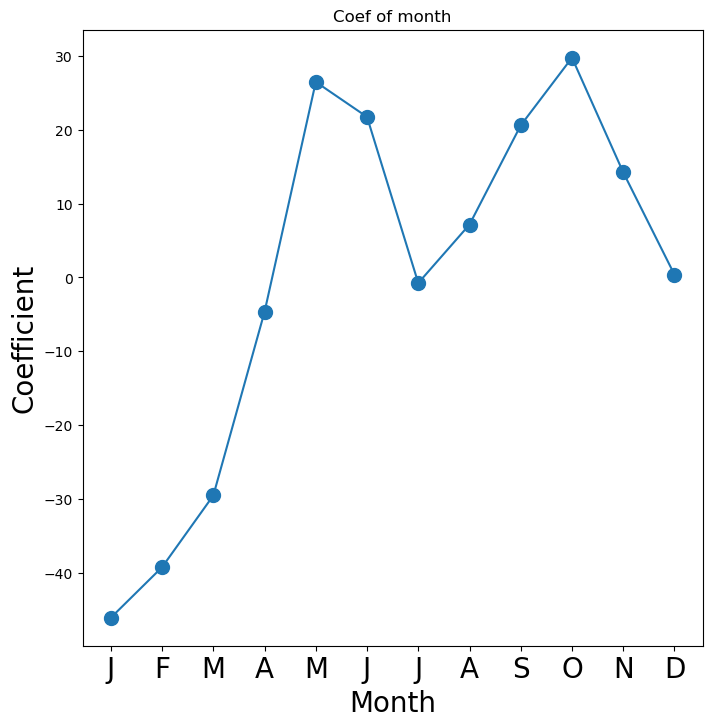

In [44]:
fig_month , ax_month = subplots(figsize=(8,8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month , coef_month , marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20);
ax_month.set_title('Coef of month')

In [45]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([coef_hr ,
                     pd.Series([-coef_hr.sum()], index=['hr[23]'])
                    ])

Text(0.5, 1.0, 'Coef of hour')

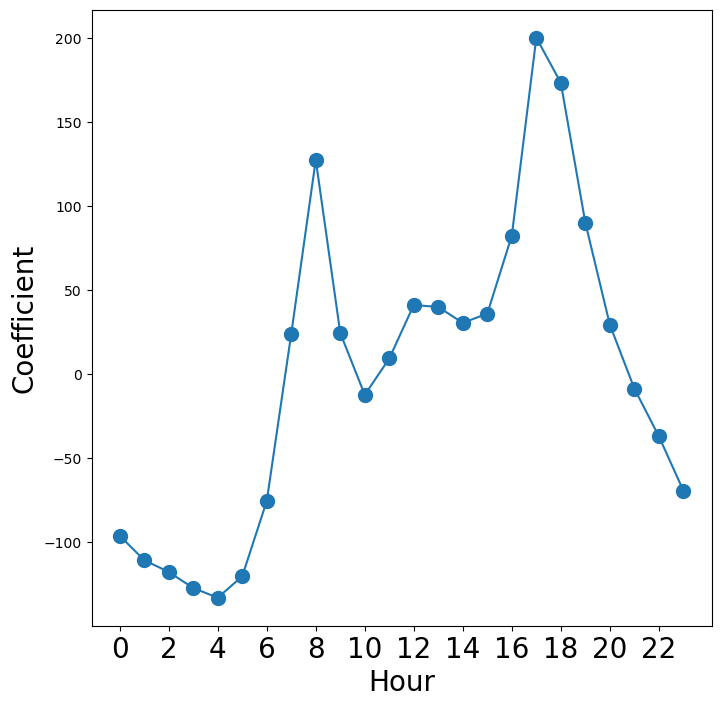

In [47]:
fig_hr , ax_hr = subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr , coef_hr , marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize =20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);
ax_month.set_title('Coef of hour')

## 4.7.2 Possion Regression

### Set-up: 
- using `sm.families.Poisson()`
- Extra: we can also use `family=sm.families.Gamma()` to fit a Gamma regression model.

In [48]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

In [52]:
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month ,
                        pd.Series([-coef_month.sum()],index=['mnth[Dec]'])
                       ])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr ,
pd.Series([-coef_hr.sum()],
          index=['hr[23]'])])

/var/folders/15/0rkxg591077df4cm7lf7jpyh0000gn/T/ipykernel_33740/3649167194.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_hr.set_xticklabels(range(24)[::2], fontsize =20)


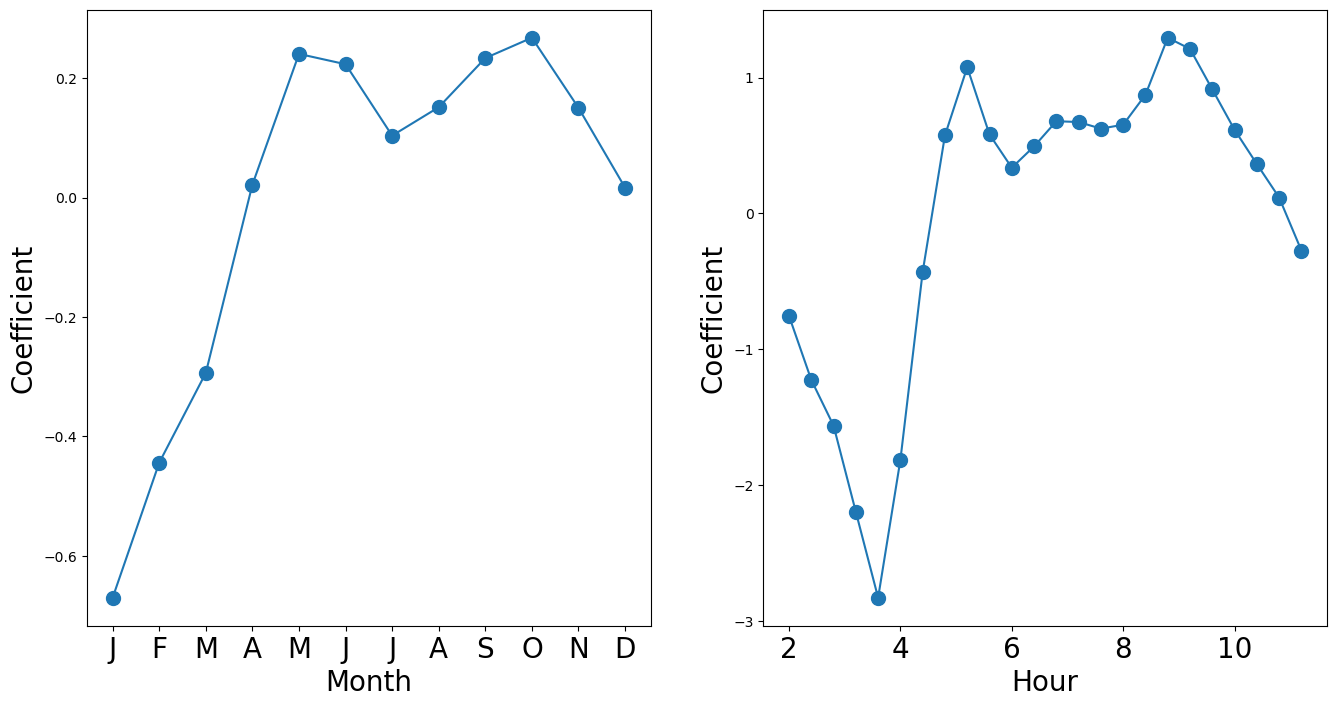

In [53]:
fig_pois , (ax_month , ax_hr) = subplots(1, 2, figsize=(16,8))
ax_month.plot(x_month , coef_month , marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)
ax_hr.plot(x_hr , coef_hr , marker='o', ms=10)
ax_hr.set_xticklabels(range(24)[::2], fontsize =20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

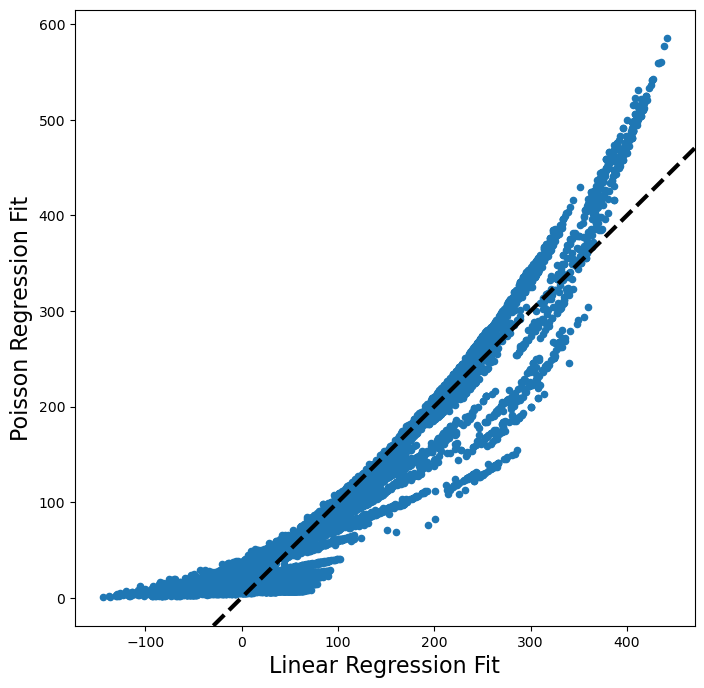

In [57]:
fig , ax = subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues, M_pois.fittedvalues , s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=16)
ax.set_ylabel('Poisson Regression Fit', fontsize=16)
ax.axline([0,0], c='black', linewidth=3, linestyle='--', slope=1);